# Submission using XGBoost

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

## Prepare data

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
df = pd.read_pickle('input/train.p')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 9 columns):
is_duplicate     404290 non-null int64
question1        404290 non-null object
question2        404290 non-null object
diff_avg_word    404290 non-null float64
tf_distance1     404290 non-null float64
tf_distance2     404290 non-null float64
cnt_distance     404290 non-null float64
jaccard_dist     404290 non-null float64
word_match       404290 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 30.8+ MB


In [35]:
training_fields = ['diff_avg_word', 'tf_distance1', 'tf_distance2', 'cnt_distance', 'jaccard_dist']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
        df[training_fields], df['is_duplicate'], test_size=0.2, random_state=42)

## Training XGBoost model

In [37]:
import xgboost as xgb

In [38]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

In [39]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.686865	valid-logloss:0.686917
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.635396	valid-logloss:0.635921
[20]	train-logloss:0.597785	valid-logloss:0.598743
[30]	train-logloss:0.569333	valid-logloss:0.570661
[40]	train-logloss:0.548056	valid-logloss:0.549607
[50]	train-logloss:0.531641	valid-logloss:0.533474
[60]	train-logloss:0.518889	valid-logloss:0.521008
[70]	train-logloss:0.508758	valid-logloss:0.511089
[80]	train-logloss:0.50065	valid-logloss:0.50319
[90]	train-logloss:0.494228	valid-logloss:0.496942
[100]	train-logloss:0.488903	valid-logloss:0.491777
[110]	train-logloss:0.484527	valid-logloss:0.487534
[120]	train-logloss:0.480775	valid-logloss:0.483918
[130]	train-logloss:0.477767	valid-logloss:0.481064
[140]	train-logloss:0.475273	valid-logloss:0.478732
[150]	train-logloss:0.47315	valid-logloss:0.476733
[160]	train-logloss:0.47138	val

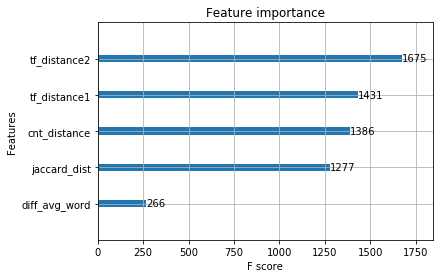

In [40]:
bst.save_model('input/bst_52.model')
xgb.plot_importance(bst)

## Submission

In [5]:
from utils import make_features

In [3]:
df_test = pd.read_csv("input/test.csv", low_memory=False, iterator=True, chunksize=600000)
df_test = pd.concat(df_test, ignore_index=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [ ]:
df_test = make_features(df_test)

Preprocessing...


In [ ]:
df_test.to_pickle('input/test.p')

In [20]:
d_test = xgb.DMatrix(df_test[training_fields])
p_test = bst.predict(d_test)

In [ ]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)